In [51]:
import sys
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from typing import Union

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.interpretation import all_expids, predselpath, return_experiments, find_experiments_with, return_unique_values, load_pred_results, compare_scores
from Medley.dataloading import get_monthly_data

In [2]:
ids = find_experiments_with(keyval_dict={'scoring':'r2','startyear':1950})

In [3]:
ids

{'0feaf5a9de',
 '36bec5369d',
 '6992361a96',
 '9809047ebb',
 'ae76a06410',
 'deb4021d58',
 'fc60bee6df',
 'fd62b92eda'}

In [4]:
test = compare_scores(ids, cv = False)

<Axes: xlabel='npredictors'>

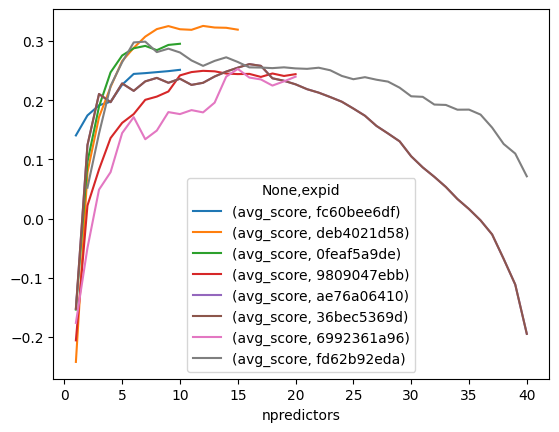

In [5]:
test.unstack(0).plot()

In [6]:
return_unique_values('firstmonth') # Reason for the worse score is including december

firstmonth  count
1           0        36bec5369d
            1        fc60bee6df
            2        561c0adbb8
            3        41eb223566
            4        ae76a06410
            5        32e6b7520d
            6        deb4021d58
            7        6034f0405d
            8        6992361a96
            9        0feaf5a9de
            10       fd62b92eda
12          0        9809047ebb
Name: expid, dtype: object

In [7]:
return_unique_values('n') # as both the best and the worst have n = 3

n  count
1  0        36bec5369d
   1        fc60bee6df
   2        561c0adbb8
   3        41eb223566
   4        ae76a06410
   5        6034f0405d
   6        0feaf5a9de
   7        fd62b92eda
3  0        9809047ebb
   1        32e6b7520d
   2        deb4021d58
   3        6992361a96
Name: expid, dtype: object

In [8]:
return_unique_values('max_depth') # Reason strong decline after 7 predictors seems to be deepest trees.

{10: ['9809047ebb', 'deb4021d58', '0feaf5a9de'],
 5: ['6034f0405d'],
 15: ['fd62b92eda']}

In [9]:
return_unique_values('min_samples_split')

{0.01: ['9809047ebb', '6034f0405d', 'fd62b92eda'], 0.001: ['deb4021d58']}

In [3]:
df_forward, sc = load_pred_results('deb4021d58')

<Axes: xlabel='npredictors'>

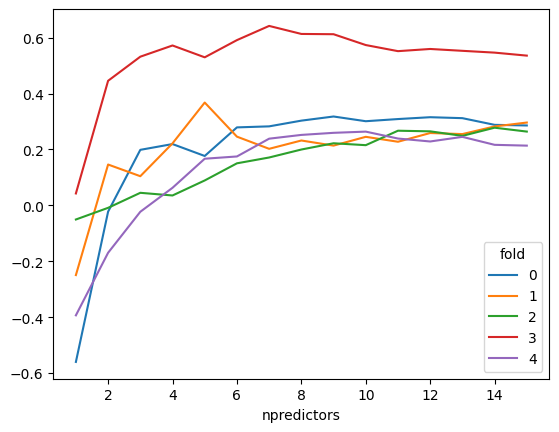

In [4]:
sc.plot()

In [5]:
df_forward.loc[10,'feature_names']

((('enso', 34, 'ersstv5'), -1),
 (('nao', 0, 'ncep'), -2),
 (('nao', 0, 'station'), -1),
 (('snao', 0, 'ncep'), -1),
 (('ao', 0, 'ncep'), -1),
 (('med_u250_latmax', 0, 'era5'), -1),
 (('med_u250', 20, 'era5'), -1),
 (('med_u250', 40, 'era5'), -3),
 (('med_u500', 50, 'era5'), -1),
 (('med_u500', 60, 'era5'), -1))

In [12]:
df_forward.loc[5,'feature_names']

((('enso', 34, 'ersstv5'), -1),
 (('nao', 0, 'station'), -1),
 (('ao', 0, 'ncep'), -1),
 (('med_u250', 20, 'era5'), -1),
 (('med_u500', 60, 'era5'), -1))

In [27]:
df_backward, sc_backward = load_pred_results('fd62b92eda')

In [8]:
df_backward.loc[5,'feature_names']

((('enso', 34, 'ersstv5'), -1),
 (('med_u250_latmax', 0, 'era5'), -1),
 (('atl_u250', 30, 'era5'), -1),
 (('med_u500', 20, 'era5'), -1),
 (('med_u500', 60, 'era5'), -1))

In [16]:
return_experiments('fc60bee6df')

{'fc60bee6df': {'prep_kwargs': {'target_region': {'include': {'iberia': [-9.8,
      35.98,
      8,
      44.6],
     'italy': [8, 35, 18, 45.63]},
    'exclude': {'north_africa': [-1.45, 34.457, 11.217, 36.972],
     'eastadriatic': [15, 43, 20, 48],
     'tunesia': [5, 30, 12, 38],
     'pyrenees': [-2, 41.8, 3.7, 45.63]}},
   'target_var': 'SPI3',
   'minsamples': 10,
   'resampling': 'multi',
   'resampling_kwargs': {'precursor_agg': 1,
    'n': 1,
    'separation': 0,
    'target_agg': 1,
    'firstmonth': 1,
    'lastmonth': 3}},
  'bottleneck_kwargs': {'startyear': 1950,
   'endyear': 2023,
   'fraction_valid': 0.8},
  'cv_kwargs': {'n_temporal': 5},
  'estimator': 'linreg',
  'estimator_kwargs': {},
  'sequential_kwargs': {'k_features': 10,
   'forward': True,
   'scoring': 'r2',
   'n_jobs': 10}}}

In [18]:
df_linreg, sc_linreg = load_pred_results('fc60bee6df')

<Axes: xlabel='npredictors'>

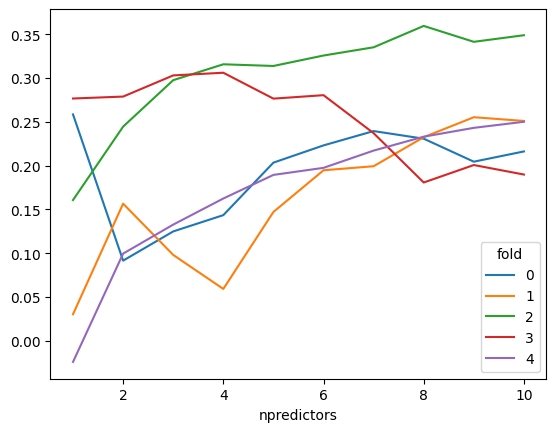

In [20]:
sc_linreg.plot()

In [26]:
df_linreg.loc[1,'feature_names']

((('ao', 0, 'trenb'), -1),)

### Method intercomparison
mlr versus rf versus xgboost

In [7]:
r2_ids = find_experiments_with(keyval_dict={'scoring':'r2','startyear':1950})

In [2]:
mse_ids = find_experiments_with(keyval_dict={'scoring':'neg_mean_squared_error','greeceplus':[18.9, 34, 37, 42.7]})
#mse_ids = find_experiments_with(keyval_dict={'scoring':'neg_mean_squared_error','estimator':'ridreg'})

In [3]:
estimators = return_unique_values('estimator')
estimators_reversed = pd.Series(estimators.index.get_level_values(0), index = pd.Index(estimators.values,name = 'expid'))

In [4]:
test = compare_scores(mse_ids, cv = False)
#test = compare_scores(r2_ids, cv = False)
# Perhaps add this latter code plus the above to the compare scores functionality?
newindex = test.index.to_frame()
newindex.loc[:,'estimator'] = estimators_reversed.reindex(test.index.get_level_values('expid')).values
test.index = pd.MultiIndex.from_frame(newindex).reorder_levels([-1,0,1])
test = test.sort_index()

<Axes: xlabel='npredictors'>

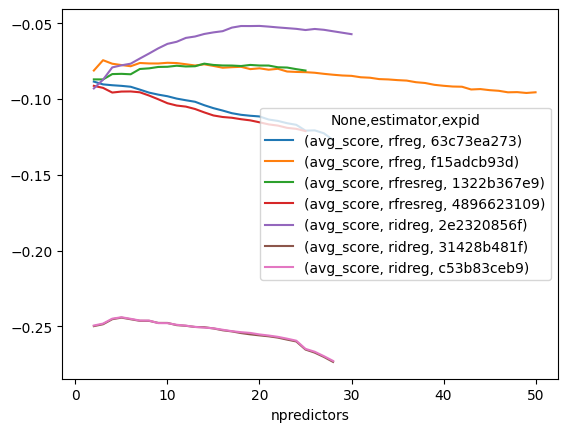

In [5]:
test.loc[(slice(None),slice(None),slice(0,50)),:].unstack([0,1]).plot()

<Axes: xlabel='npredictors'>

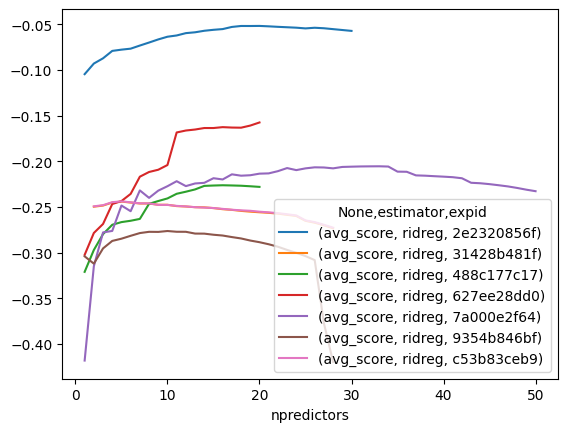

In [20]:
test.loc[(slice(None),slice(None),slice(0,50)),:].unstack([0,1]).plot()

In [6]:
mse_ids

{'1322b367e9',
 '2e2320856f',
 '31428b481f',
 '4896623109',
 '63c73ea273',
 'c53b83ceb9',
 'f15adcb93d'}

<Axes: xlabel='npredictors'>

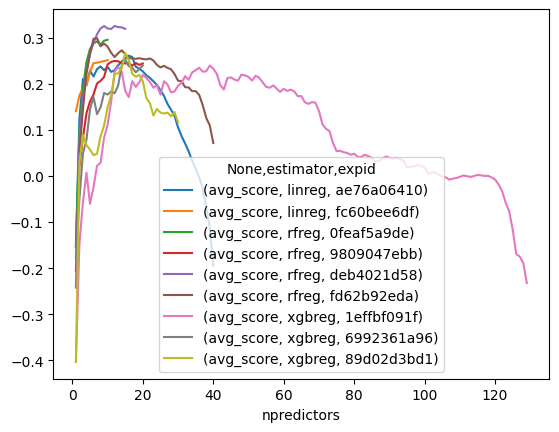

In [10]:
test.unstack([0,1]).plot()

In [11]:
estimators

estimator  count
xgbreg     0        1effbf091f
           1        efdddde0ef
           2        32e6b7520d
           3        6992361a96
           4        89d02d3bd1
ridreg     0        c53b83ceb9
           1        488c177c17
           2        7a000e2f64
           3        627ee28dd0
           4        31428b481f
           5        2e2320856f
           6        9354b846bf
linreg     0        fc60bee6df
           1        561c0adbb8
           2        41eb223566
           3        ae76a06410
           4        d0f4626d4f
rfreg      0        9809047ebb
           1        63c73ea273
           2        deb4021d58
           3        6034f0405d
           4        0feaf5a9de
           5        4f047da3ed
           6        fd62b92eda
           7        f15adcb93d
           8        730276d8e3
rfresreg   0        e50a950851
Name: expid, dtype: object

### Checking the amounts of times a predictor is selected (over all experiments)

In [5]:
ids = list(find_experiments_with('target_var', 'SPI3'))
scores = return_unique_values('scoring', reverse = True)

In [64]:
subset = list()
for expid in ids:
    df, sc = load_pred_results(expid)
    # Set a quality requirement
    max_score = df['avg_score'].max()
    if ((scores[expid] == 'neg_mean_squared_error') and max_score > -0.3) or ((scores[expid] == 'neg_mean_squared_error') and max_score > 0.1):
        try:
            prednames = df.loc[10,'feature_names']
        except KeyError: # other maximum
            prednames = df.loc[df.index.max(),'feature_names']
        prednames = [t[0] for t in prednames] # disregard lagged
        subset.extend(prednames)
subset = pd.Index(subset)#.drop_duplicates()

In [65]:
da = get_monthly_data()

In [66]:
da.columns.intersection(subset)

MultiIndex([(           'enso',    12,  'ersstv5'),
            (           'enso',     3,  'ersstv5'),
            (           'enso',    34,  'ersstv5'),
            (           'enso',     4,  'ersstv5'),
            (            'amo',     0,  'ersstv5'),
            (            'amo',     0,  'hadsst4'),
            (            'nao',     0,     'ncep'),
            (            'nao',     0,  'station'),
            (           'snao',     0,     'ncep'),
            (             'ao',     0,     'ncep'),
            (             'ao',     0,    'trenb'),
            (             'ea',     0,     'ncep'),
            (            'pdo',     0,  'ersstv5'),
            (           'gmst',     0, 'hadcrut5'),
            (            'qbo',     0,     'ncep'),
            ('med_u250_latmax',     0,     'era5'),
            (       'med_u250',    20,     'era5'),
            (       'med_u250',    30,     'era5'),
            (       'med_u250',    40,     'era5'),
            

In [69]:
subset.value_counts()

2                             13
(westind, 5070, hadisst)      10
1                             10
(nao, 0, station)              9
(eastind, 90110, hadisst)      7
(med_u500, 30, era5)           6
(amo, 0, ersstv5)              6
(ao, 0, trenb)                 6
(iod, 0, hadisst)              6
(enso, 34, ersstv5)            5
(med_u500, 60, era5)           5
(med_u250, 30, era5)           5
(amo, 0, hadsst4)              5
(snao, 0, ncep)                5
(med_u250, 60, era5)           4
(atl_u500_latmax, 0, era5)     4
(vortex_u20, 7080, era5)       4
(med_u500, 20, era5)           4
(med_u250, 40, era5)           4
(med_u250_latmax, 0, era5)     3
(atl_u250, 20, era5)           3
(ea, 0, ncep)                  3
(atl_u500, 60, era5)           3
(atl_u500, 50, era5)           3
(enso, 3, ersstv5)             3
(atl_u250, 50, era5)           2
(nao, 0, ncep)                 2
6                              2
(atl_u500, 30, era5)           2
(med_u250, 20, era5)           2
(med_u500_